# *Práctica LAB1 IA Generativa - Uso avanzado de RNN*


GRUPO: A08

CARLOS OCON GARAY.

PEDRO GARCIA SILGO

Para esta práctica se pide lo siguiente. En ploblema de pronóstico de temperatura, se puede mejorar el rendimiento de muchas maneras:


1. Ajustar la cantidad de unidades en cada capa recurrente en la configuración apilada, así como la cantidad de dropout.
2. Ajustar la tasa de aprendizaje utilizada por el optimizador RMsprop o probar con un optimizador diferente.
3. Utilizar una pila de capas Dense como regresor encima de la capa recurrente, en lugar de una capa Dense.
4. Mejorar la entrada al modelo: intentar usar secuencias más largas o más cortas, o usar una tasa de muestreo diferente, o hacer ingeniería de características.



Para cumplir con los objetivos, se realizarán pautas para ver como mejoran o empeoran los modelos para acercarse a un modelo más preciso. Pero, al no haber una teoría específica de cómo mejorar un modelo, se recurre al acierto y al error.

Por ejemplo, los modelos de series temporales no funcionan en todos los ámbitos donde el tiempo es importante. En la bolsa, por ejemplo, no se puede preveer qué pasará observando el pasado.

Una vez sabido esto, se prosigue con la práctica.

### Librerías

In [38]:
!pip install keras-tuner

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import keras_tuner

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   ---------------------------------------- 129.1/129.1 kB 1.9 MB/s eta 0:00:00


C:\Users\fosky\AppData\Local\Temp\ipykernel_21460\3191593513.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [39]:
# Se descargan los datos
df = pd.read_csv('jena_climate_2009_2016.csv')
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
print(df.shape)
df.head()

(420451, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [40]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


A simple vista, los datos parecen correctos y no tienen fallas.

### Dirección del viento

Puede ser que haya datos que indiquen lo mismo. En el caso de la dirección del viento, 0º y 360º indican lo mismo. Para tratar este problema, se pueden usar senos y cosenos para representar vectores, asi indican lo mismo y no mediante nùmeros.

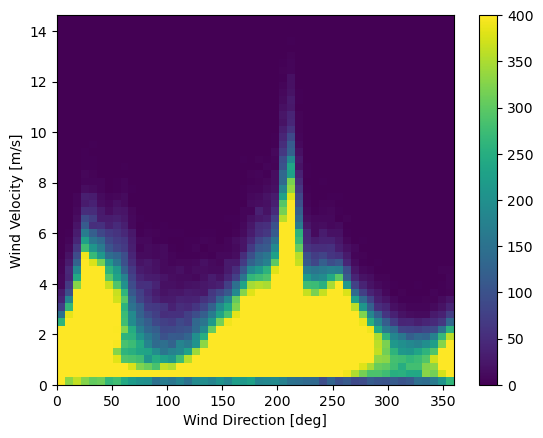

In [41]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.show()

Según la gráfica, los datos están dispersos y no se saca nada en claro.

Pero, si se transforman a vectores, se puede llegar a ver similitudes o patrones.

In [42]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-12.185637751588763, 8.475086644274262, -8.27438540335515, 7.849152333233395)

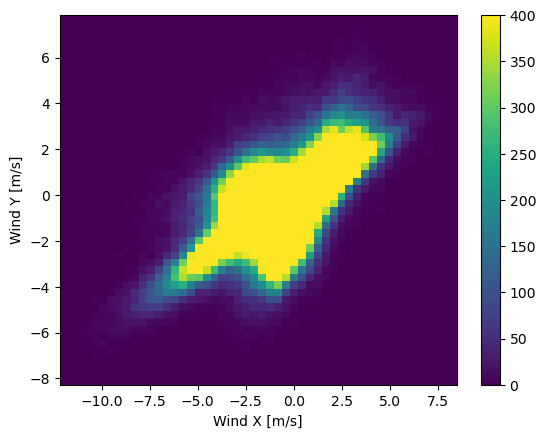

In [43]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Además, de esta manera, el modelo aprende mejor Por lo que, al transformar los datos, se añade información que de la ora manera no se habría obtenido, como la relación espacial, la proximidad angular o la dispersoón reducida.

### Tiempo

Otra de las variables fundamentales es el tiempo. Los datos se miden cada 10 minutos, pero para predecir los datos, se utilizan los 50 minutos antes de los 10 donde marca la temperatura.

In [44]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

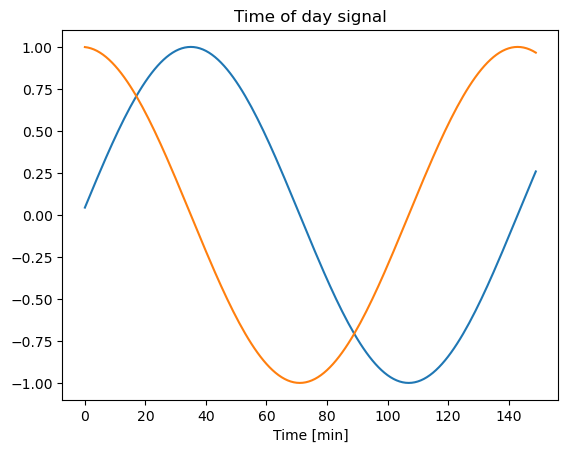

In [45]:

plt.plot(np.array(df['Day sin'])[:25*6])
plt.plot(np.array(df['Day cos'])[:25*6])
plt.xlabel('Time [min]')
plt.title('Time of day signal')
plt.show()

Si se representan tanto la hora y día como funciones sinusoidales, se muestra periodicidad.

### Temperatura

Otra manera de reducir el ruido y acercar más el modelo a uno más optimo, es utilizar la media movil de la temperatura de los primeros 50 minutos. Además, esto puede ser imoortante ante los cambios bruscos de temperatura. Puede avisar de algun suceso.

### Dataset

In [46]:
temperature = np.zeros((df.shape[0],))
raw_data = np.zeros((df.shape[0], df.shape[1] - 1))
for i, values in enumerate(df.to_numpy()):
    # Guardamos columna 1 en el array temperatura
    temperature[i] = values[1]
    # Guardamos todas las columnas (temperatura
    # incluida) en el array raw_data
    raw_data[i, :] = values[1:]

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Para poder mejorar el modelo como se pide en la práctica, se va a crear el dataset con los datos normalizados.

In [47]:
# Normalizar datos
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# -----------------------------------
# Normalizar temperatura de salida
# -----------------------------------
out_mean =  temperature[:num_train_samples].mean(axis=0)
temperature -= out_mean
out_std = temperature[:num_train_samples].std(axis=0)
temperature /= out_std


# Crear timeseries_dataset_from_array
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [55]:
# !CUIDADO. Elimina los resultados de las anteriores búsquedas ejecutadas en una misma sesión de colab
!rm -r keras_tuner_results/rnn_regression_tuning/*

"rm" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [53]:
# --------------------------------------
# CUIDADO! Tarda mucho en terminar de ejcutarse
# --------------------------------------

import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from kerastuner.tuners import RandomSearch


# Define your RNN model for regression
def build_model(hp):

    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = LSTM(
          units=hp.Choice('units', values=[32,64,128]),
          #recurrent_dropout=hp.Choice('recurrent_dropout', values=[0.25, 0.5, 0.75]), # -> Muy lento (no utiliza GPU)
        )(inputs)
    # Para regularizar la capa Dense, también agregamos
    # una capa Dropout después del LSTM.
    x = Dropout(hp.Choice('dense_dropout', values=[0.25, 0.5, 0.75]))(x)

    for i in range(hp.Choice('dense_ffw', values=[0, 1, 2, 3])):
      x = Dense(
            hp.Choice(f'dense_{i}', values=[32, 64, 128]),
            activation='relu'
          )(x)

    outputs = Dense(1)(x)

    model = keras.Model(inputs, outputs)

    # compile
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    lr = hp.Choice('learning_rate', values=[0.0005, 0.005, 0.05])

    if optimizer_choice == 'adam':
      optimizer = Adam(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
      optimizer = RMSprop(learning_rate=lr)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mae'])

    return model


# Initialize the Keras Tuner RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # You can adjust this based on your resources and requirements
    directory='keras_tuner_results',
    project_name='rnn_regression_tuning'
)

# Perform the search

# ---------------------------------------------------
# NOTA! Dado que para la búsqueda de hiperparam. se
# utilizará una muestra reducida del conjunto total
# de entrenamiento se seleccionará un subconjunto
# aleatorio para train_hp y val_hp
# Para ello seguiremos una lógica temporal
# - train_hp: muestra aleatoria de los primeros 881 reg.
# - val_hp: muestra aleatoria de los últimos 50 reg.
# ---------------------------------------------------

# 180 lotes aleatorios para entrenar
train_dataset_hp = train_dataset.skip(
    train_dataset.cardinality().numpy()-190
).take(180).shuffle(buffer_size=180, reshuffle_each_iteration=True)

# 10 lotes aleatorios de entro los últimos 50 para validar
val_dataset_hp = train_dataset.skip(
    train_dataset.cardinality().numpy()-10
)


tuner.search(train_dataset_hp, epochs=3, validation_split=0.2, validation_data=val_dataset_hp)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 00m 52s]
val_loss: 0.1716156303882599

Best val_loss So Far: 0.09563760459423065
Total elapsed time: 00h 12m 52s


In [61]:
hyperparameters = best_hps.values
print(hyperparameters)

{'units': 64, 'dense_dropout': 0.25, 'dense_ffw': 1, 'optimizer': 'adam', 'learning_rate': 0.005, 'dense_0': 32, 'dense_1': 128, 'dense_2': 32}


Estos son los parámetros obtenidos:


* 'units': 64
* 'dense_dropout': 0.25
* 'dense_ffw': 1
* 'optimizer': 'adam'
* 'learning_rate': 0.005
* 'dense_0':32
* 'dense_1': 128
* 'dense_2': 32


In [62]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = LSTM(
      units=64,
      #recurrent_dropout=hp.Choice('recurrent_dropout', values=[0.25, 0.5, 0.75]), # -> Muy lento (no utiliza GPU)
    )(inputs)
# Para regularizar la capa Dense, también agregamos
# una capa Dropout después del LSTM.
x = Dropout(0.25)(x)

x = Dense(32,activation='relu')(x)
x = Dense(128,activation='relu')(x)
x = Dense(32,activation='relu')(x)

outputs = Dense(1)(x)

# Build the final model with the best hyperparameters
final_model = keras.Model(inputs, outputs)

# compile
optimizer = Adam(learning_rate=0.005)

final_model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae'])

# Train the final model with your full dataset
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

final_model.fit(train_dataset, epochs=25, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/25
819/819 ━━━━━━━━━━━━━━━━━━━━ 107s 128ms/step - loss: 0.1493 - mae: 0.2934 - val_loss: 0.1295 - val_mae: 0.2799
Epoch 2/25
819/819 ━━━━━━━━━━━━━━━━━━━━ 104s 127ms/step - loss: 0.0811 - mae: 0.2215 - val_loss: 0.1644 - val_mae: 0.3136
Epoch 3/25
819/819 ━━━━━━━━━━━━━━━━━━━━ 106s 129ms/step - loss: 0.0515 - mae: 0.1765 - val_loss: 0.1762 - val_mae: 0.3249
Epoch 4/25
819/819 ━━━━━━━━━━━━━━━━━━━━ 104s 128ms/step - loss: 0.0382 - mae: 0.1518 - val_loss: 0.1732 - val_mae: 0.3223
Epoch 5/25
819/819 ━━━━━━━━━━━━━━━━━━━━ 99s 121ms/step - loss: 0.0318 - mae: 0.1386 - val_loss: 0.1889 - val_mae: 0.3383
Epoch 6/25
819/819 ━━━━━━━━━━━━━━━━━━━━ 103s 125ms/step - loss: 0.0265 - mae: 0.1265 - val_loss: 0.1844 - val_mae: 0.3346
Epoch 7/25
819/819 ━━━━━━━━━━━━━━━━━━━━ 110s 135ms/step - loss: 0.0243 - mae: 0.1208 - val_loss: 0.1922 - val_mae: 0.3410
Epoch 8/25
819/819 ━━━━━━━━━━━━━━━━━━━━ 118s 144ms/step - loss: 0.0244 - mae: 0.1203 - val_loss: 0.1919 - val_mae: 0.3385
Epoch 9/25
819/819 ━━━━━━

Segun el historial, el modelo puede reducir el error y el mae hasta la época 15-16, y como el programa sigue, empieza el sobreentrenamiento.

Para tratar de quitar el overfitting, se utiliza el recurrent dropout.

In [ ]:
# --------------------------------------
# CUIDADO! Tarda mucho en terminar de ejcutarse
# --------------------------------------

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = LSTM(
      units=128,
      recurrent_dropout=0.25, # -> Muy lento (no utiliza GPU)
    )(inputs)
# Para regularizar la capa Dense, también agregamos
# una capa Dropout después del LSTM.
x = Dropout(0.5)(x)

x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(32,activation='relu')(x)

outputs = Dense(1)(x)

# Build the final model with the best hyperparameters
final_model = keras.Model(inputs, outputs)

# compile
optimizer = Adam(learning_rate=0.005)

final_model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae'])

# Train the final model with your full dataset
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

final_model.fit(train_dataset,
                epochs=18,
                validation_data=val_dataset,
                callbacks=callbacks)

Epoch 1/18
819/819 ━━━━━━━━━━━━━━━━━━━━ 305s 367ms/step - loss: 0.1589 - mae: 0.3047 - val_loss: 0.1184 - val_mae: 0.2685
Epoch 2/18
819/819 ━━━━━━━━━━━━━━━━━━━━ 300s 366ms/step - loss: 0.1097 - mae: 0.2587 - val_loss: 0.1192 - val_mae: 0.2687
Epoch 3/18
819/819 ━━━━━━━━━━━━━━━━━━━━ 301s 368ms/step - loss: 0.0898 - mae: 0.2340 - val_loss: 0.1226 - val_mae: 0.2731
Epoch 4/18
819/819 ━━━━━━━━━━━━━━━━━━━━ 312s 381ms/step - loss: 0.0739 - mae: 0.2124 - val_loss: 0.1357 - val_mae: 0.2867
Epoch 5/18
432/819 ━━━━━━━━━━━━━━━━━━━━ 1:59 309ms/step - loss: 0.0643 - mae: 0.1979

Debido a que la capa LSTM con recurrent dropout no utiliza la potencia de la GPU el entrenamiento es muy lento.



### Resultados

Las mejoras a los modelos son las siguientes:


1. Vectorizar la dirección del viento.
2. Transformación del tiempo a funciones sinusoidales
3. Normalizar los valores de salida.

Además, con el recurrent dropout reduce el sobreentrenamiento.

